## Introduction 

## Dataset and Strategy

## Season Average, the slow way

In [1]:
import pandas



In [2]:
df_teams = pandas.read_csv('Teams.csv')
df_regular_season = pandas.read_csv('RegularSeasonDetailedResults.csv')


In [3]:
df_regular_season.columns

Index([u'Season', u'Daynum', u'Wteam', u'Wscore', u'Lteam', u'Lscore', u'Wloc',
       u'Numot', u'Wfgm', u'Wfga', u'Wfgm3', u'Wfga3', u'Wftm', u'Wfta',
       u'Wor', u'Wdr', u'Wast', u'Wto', u'Wstl', u'Wblk', u'Wpf', u'Lfgm',
       u'Lfga', u'Lfgm3', u'Lfga3', u'Lftm', u'Lfta', u'Lor', u'Ldr', u'Last',
       u'Lto', u'Lstl', u'Lblk', u'Lpf'],
      dtype='object')

In [4]:
frames = []
for season in df_regular_season.Season.unique():
    team_season = df_teams.copy()
    team_season['season'] = season
    team_season.index = team_season.Team_Id.apply(str) + team_season.season.apply(str)
    frames.append(team_season)

df_team_seasons = pandas.concat(frames)

print df_team_seasons.head()


          Team_Id    Team_Name  season
11012003     1101  Abilene Chr    2003
11022003     1102    Air Force    2003
11032003     1103        Akron    2003
11042003     1104      Alabama    2003
11052003     1105  Alabama A&M    2003


In [5]:
loser_columns = ['Lscore', 'Lfgm', 'Lfga', 'Lfgm3', 'Lfga3','Lftm', 'Lfta', 'Lor', 'Ldr', 'Last', 'Lto', 'Lstl', 'Lblk', 'Lpf']
winner_columns = ['Wscore', 'Wfgm', 'Wfga', 'Wfgm3', 'Wfga3', 'Wftm', 'Wfta', 'Wor', 'Wdr', 'Wast', 'Wto', 'Wstl', 'Wblk', 'Wpf']
fixed_columns = [column[1:] for column in winner_columns]



In [7]:
season_averages = []
for index, row in df_team_seasons.iterrows():
    wins = df_regular_season.Wteam == row.Team_Id
    loses = df_regular_season.Lteam == row.Team_Id
    right_season = df_regular_season.Season == row.season

    won_games = df_regular_season[right_season & wins][winner_columns]
    won_games.columns = fixed_columns

    lost_games = df_regular_season[right_season & loses][loser_columns]
    lost_games.columns = fixed_columns

    games = pandas.concat([won_games, lost_games]).mean()
    games['Team_Id'] = row.Team_Id
    games['Season'] = row.season
    games['Team_Name'] = row.Team_Name
    games = games.to_frame().transpose()

    season_averages.append(games)

season_averages = pandas.concat(season_averages).dropna()


## Season Average, but quicker

In [8]:
loss_cols = ['Season', 'Lteam', 'Lscore', 'Lfgm', 'Lfga', 'Lfgm3', 'Lfga3',
             'Lftm', 'Lfta', 'Lor', 'Ldr', 'Last', 'Lto', 'Lstl', 'Lblk',
             'Lpf']
win_cols = ['Season', 'Wteam', 'Wscore', 'Wfgm', 'Wfga', 'Wfgm3', 'Wfga3',
            'Wftm', 'Wfta', 'Wor', 'Wdr', 'Wast', 'Wto', 'Wstl', 'Wblk',
            'Wpf']

renamed_cols = [col[1:] if col.startswith("W") else col for col in win_cols]


In [9]:


df_win = df_regular_season[win_cols].copy()
df_win.columns = renamed_cols

df_loss = df_regular_season[loss_cols].copy()
df_loss.columns = renamed_cols


df_all = pandas.concat([df_win, df_loss])

In [10]:
df_mean = df_all.groupby(['team', "Season"], as_index=False).agg("mean")

##  Merge seeds

In [12]:
import numpy

df_seeds = pandas.read_csv("TourneySeeds.csv")


# Seed is a string which includes division, e.g. "W08"
# TIP: use built-in `str.slice()`, not map/lambda
df_seeds["Seed"] = df_seeds["Seed"].str.slice(1, 3).astype(numpy.int32)

# Convert to seed and team IDs to int
# TIP: use built-in `astype()`, not map/conversion
df_seeds["Season"] = df_seeds["Season"].astype(numpy.int32)
df_seeds["Team"] = df_seeds["Team"].astype(numpy.int32)


# Add the seeds to the feature vectors 
df_features = df_mean.merge(df_seeds, how="left",
                            left_on=["team", "Season"],
                            right_on=["Team", "Season"])

# Set seeds for unseeded teams to 17 (null is result of merge)
# TIP: use double index in `.loc[]`, not two index operations
df_features.loc[df_features["Seed"].isnull(), "Seed"] = 17

# We don't need the team name string in the feature vectors
del df_features["Team"]


df_features.head()


,team,Season,score,fgm,fga,fgm3,fga3,ftm,fta,or,dr,ast,to,stl,blk,pf,Seed
0,1101,2014,63.142857,20.333333,50.142857,6.666667,17.857143,15.809524,21.190476,8.000000,20.333333,10.000000,15.000000,5.761905,1.476190,21.571429,17.0
1,1101,2015,61.000000,21.428571,52.928571,7.250000,19.178571,10.892857,14.964286,8.250000,19.642857,11.857143,12.821429,5.928571,1.178571,20.607143,17.0
2,1101,2016,69.851852,23.814815,53.925926,6.851852,18.851852,15.370370,21.740741,8.185185,22.518519,12.888889,13.407407,6.740741,2.444444,22.370370,17.0
3,1101,2017,67.880000,24.440000,53.320000,7.080000,19.080000,11.920000,18.560000,7.560000,22.880000,13.600000,14.480000,7.000000,2.760000,22.160000,17.0
4,1102,2003,57.250000,19.142857,39.785714,7.821429,20.821429,11.142857,17.107143,4.178571,16.821429,13.000000,11.428571,5.964286,1.785714,18.750000,17.0


## Training Data

In [13]:
df_regular_season = pandas.read_csv("RegularSeasonCompactResults.csv")


matchup_rename_columns = ["Season", "home_score", "home_team",
                          "away_score", "away_team"]

df_wins = df_regular_season[["Season", "Wscore", "Wteam",
                             "Lscore", "Lteam"]]
df_wins.columns = matchup_rename_columns

df_losses = df_regular_season[["Season", "Lscore", "Lteam",
                               "Wscore", "Wteam"]]
df_losses.columns = matchup_rename_columns

df_matchups = pandas.concat([df_wins, df_losses])

In [14]:
df_matchups.head()

,Season,home_score,home_team,away_score,away_team
0,1985,81,1228,64,1328
1,1985,77,1106,70,1354
2,1985,63,1112,56,1223
3,1985,70,1165,54,1432
4,1985,86,1192,74,1447


### Merge/join features

In [16]:
df_matchups = df_matchups.merge(df_features, how="inner",
                                left_on=["Season", "home_team"],
                                right_on=["Season", "team"],
                                suffixes=("_", "_home"))

df_matchups = df_matchups.merge(df_features, how="inner",
                                left_on=["Season", "away_team"],
                                right_on=["Season", "team"],
                                suffixes=("_home", "_away"))

## Prepare model input features

In [17]:
from sklearn import preprocessing

input_columns = [col for col in df_matchups.columns 
                 if not (col.startswith("team_")) 
                 and (col.endswith("_away") or col.endswith("_home"))]

x_unscaled = df_matchups[input_columns] 
scaler = preprocessing.RobustScaler()
x = scaler.fit_transform(x_unscaled)

## Prepare model target/output features 

* We're doing supervised machine learning, so we need a target to predict
* Target is whether or not the "home team" will win

In [72]:
df_matchups["home_win"] = (df_matchups["home_score"] >
                           df_matchups["away_score"])

y = df_matchups["home_win"].astype(int)

In [73]:
from sklearn import model_selection 


x_train, x_test, y_train, y_test = (model_selection
                                    .train_test_split(x, y, test_size=0.2,
                                                      random_state=42,
                                                      stratify=y))


## Train a gradient boosted tree 

In [27]:
from sklearn import ensemble

model_gbm = ensemble.GradientBoostingClassifier(n_estimators=120,
                                                subsample=0.75,
                                                learning_rate=0.25,
                                                max_depth=3)

model_gbm.fit(x_train, y_train)

print "Accuracy: %s" % model_gbm.score(x_test, y_test)

Accuracy: 0.727842113848


## Train a basic neural network


In [74]:
from keras import models
from keras import optimizers

from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier

def make_model():
    model = models.Sequential()
    model.add(layers.Dense(units=100, input_dim=len(input_columns)))
    model.add(layers.Activation('sigmoid'))
    model.add(layers.Dense(units=2))
    model.add(layers.Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(lr=0.001),
                  metrics=['accuracy'])
    return model



In [75]:
from keras.utils import np_utils

y_cat_train = np_utils.to_categorical(y_train)
y_cat_test = np_utils.to_categorical(y_test)


In [76]:
model = KerasClassifier(make_model)
history = model.fit(x_train, y_train, batch_size=100, epochs=10, verbose=0,
                    validation_data=(x_test, y_cat_test))
print "score:", model.score(x_test, y_test, verbose=0)

score: 0.731724025419


(0.7, 0.75)

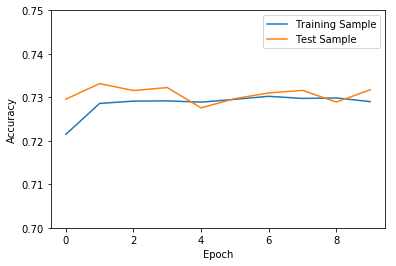

In [84]:
from matplotlib import pyplot
%matplotlib inline

pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])

pyplot.legend(["Training Sample", "Test Sample"])
pyplot.xlabel("Epoch")
pyplot.ylabel("Accuracy")
pyplot.ylim([0.7, 0.75])